# Video hashing based on low-rank frames
https://ietresearch.onlinelibrary.wiley.com/doi/epdf/10.1049/ipr2.12351

![](paper/img/videohashing1png.png)

* using **the low-rank approximation of SVD** (singluar value decomposition) => large singular values (low-rank frame calculation)
* **two-dimensional discrete wavelet transform (DWT)** is applied to every low-rank frame 
* and **the mean of low-frequency DWT coefficients is selected as a hash element**
  * Since these coefficientscan represent input data approximately, hash discrimination is thus ensured
  * Experimentswith 16,850 videos are carried out to test performances of the proposed algorithm.
  * Theresults show that the proposed algorithm outperforms some well-known video hashingalgorithms in computational time and classification about discrimination and robustness

## Notes.
* video hashing based on low-rank frames는 근본적으로 영상의 모든 프레임 집합의 평균값을 사용하는 해싱 알고리즘을 제안한다.
* 이 방식의 가장 기초적인 접근은, 비디오 프레임들의 픽셀값 평균을 사용하여 비디오를 분류하고 유사도를 측정하는 것이다.
* 이 방식의 가진 단점은 수백 개의 프레임들로 구성되었더라도 전체 비디오 시퀀스를 하나의 요소로 압축한다는 것
    * => 수백 장의 프레임들을 하나의 정보값이 대표하게 됨

### How to fix(bypass) problem?
* SVD를 전체 프레임이 아니라 일정 갯수로 분할한 여러 개의 프레임 그룹에 대해 수행한다
* 따라서 하나의 비디오는 여러 개의 hash로 구성되며
  * 최근접 이웃 탐색 시, one-to-one이 아닌 many-to-many 기반으로 수행한다


# Result (22.07.14 updated)

In [7]:
# from datetime import timedelta
# import cv2
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns
import random
from numpy.linalg import svd
from glob import glob

from random import randrange
from PIL import Image
import pywt

import copy
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from scipy.stats import kurtosis
from scipy.stats import skew

sys.path.insert(0, "utils/")
from preprocess import get_bbox_max_width_height, get_stats, pose_with_topk_joints
from distance import cosine_dist_xy_flatten, cosine_dist_xy
from visualize import multi_displot
from scipy.spatial.distance import cosine

In [8]:
# def hash_video_svd_wavelet(video, group_num=16, target_frame=256):
#     if len(video) > target_frame:
#         video = reduce_frame_to_target(video, target_frame)
#     else:
#         video = expand_frame_to_target(video, target_frame)

#     groups = group_frame_to_target(video, group_num)
#     low = np.array([[SVD_reconstruct(f) for f in group] for group in groups])
#     lowrank = np.array(calculate_low_rank(low))

#     return np.array(approximate_low_rank(lowrank))

def reduce_frame_to_target(input_data, target):
    start = input_data.shape[0]
    assert start >= target, "input frame number must be equal to or larger than target frame number"
    if start == 256:
        return input_data

    output_data = np.zeros((target, input_data.shape[1], input_data.shape[2]))

    # 첫번째 / 마지막 데이터 할당
    output_data[0,:,:] = input_data[0,:,:]
    output_data[-1,:,:] = input_data[-1,:,:]

    # 남아있는 갯수
    interval_cnt = target - 2    
    remains = start - target
    if remains == 0:
        remains_interval = 1
    else:
        remains_interval = max(target // remains, 1) # prevent zero division
    
    in_idx = 1 # input starting index
    out_idx = 1 # output starting index

    # 기본적으로 한개씩 집어넣기
    for j in range(1, interval_cnt + 1, max(target // interval_cnt, 1)): # 남아있는 갯수에 대해 for loop
        # 마지막을 제외한 모든 값이 채워지면 루프 종료
        if out_idx >= target - 1:
            break
        else:
            if j % remains_interval == 0: # remains를 추가로 더해줄 interval
                # print(in_idx)
                output_data[out_idx,:,:] = input_data[in_idx,:,:]
                in_idx += 2 # input 프레임 1개를 추가 스킵 (건너뛰기)
                out_idx += 1
                if out_idx >= target - 1:
                    break            
        output_data[out_idx,:,:] = input_data[in_idx,:,:]
        in_idx += 1
        out_idx += 1

    if output_data.shape[0] > target:
        return output_data[target, :, :]
    elif output_data.shape[0] < target:
        return None
    return output_data

# 1. 256보다 크게, 등간격, 빈 곳은 우선 0 채우기

def expand_frame_to_target(input_data, target):

    if input_data.shape[0]==256:
        return input_data

    ### frame expansion
    start = input_data.shape[0]
    least_coef = target // start

    while (start - 1) * least_coef < target:
        least_coef += 1

    # debugging print    
    # print(f'start:{start}, least_coef:{least_coef}, mid_frame:{input_data.shape[0]*least_coef}, target:{target}')
    
    output_data = np.zeros((input_data.shape[0]*least_coef, input_data.shape[1], input_data.shape[2]))
    # print(output_data.shape)

    input_idx = 0
    for i in range(int(input_data.shape[0] * least_coef)):
        if i % least_coef==0:
            output_data[i] = input_data[input_idx]
            input_idx += 1

    # return output_data

    # delete last (least_coef - 1) frames
    output_data = output_data[:-1*(least_coef-1), :, :]
    # print('mid-cut shape', output_data.shape)
    # print('mid-cut last element', output_data[-1,:,:])

    ### interpolate in-between frames
    for i in range(output_data.shape[0]):
        # if i % least_coef == 0:
        try:
            # print(i, least_coef*i, least_coef*(i+1))
            output_data[least_coef*i:least_coef*(i+1), :, :] = np.linspace(output_data[least_coef*i,:,:],
                                                                            output_data[least_coef*(i+1),:,:],
                                                                            least_coef)
        except:
            # print('break')
            break
    
    ## reduce frames to target number
    output_data = reduce_frame_to_target(output_data, target)

    # print(output_data.shape)
    return output_data

def group_frame_to_target(input_data, target=16):
    num_group = int(input_data.shape[0] / target)
    return [input_data[num_group*i : num_group*(i+1), :, :] for i in range(num_group)]

def SVD_reconstruct(frame, r = 2):
    # for each frame
    U, Sigma, Vt = svd(frame)
    # print(Sigma)
    Sigma = np.diag(Sigma)
    # print(Sigma)
    return U[:,:r] @ Sigma[:r,:r] @ Vt[:r,:]


def calculate_low_rank(video_groups):
    # expected input dimension : (video_group_num, 256 / video_group_num, keypoint_num, 2)
    # example: (16, 16, 19, 2)
    
    video_group_cnt = video_groups.shape[0] # 16
    keypoint_cnt = video_groups.shape[2] # 19

    out = np.zeros(video_groups.shape[1:]) # (16,19,2)
    
    for i in range(video_group_cnt):
        for j in range(keypoint_cnt):
            out[i,j,0] = video_groups[i, :, j, 0].mean()
            out[i,j,1] = video_groups[i, :, j, 1].mean()

    return out

def approximate_low_rank(cluster):
    LL, (LH, HL, HH) = pywt.dwt2(cluster, "haar")
    # print(LL.shape)

    d_a = LL.shape[-2]
    d_b = LL.shape[-1]

    result = (LL.sum(axis=-2) / (d_a * d_b)).ravel()
    # print(result.shape)
    return result


In [9]:
def hash_video_svd_wavelet(video, group_num=16, target_frame=256):
    if len(video) > target_frame:
        video = reduce_frame_to_target(video, target_frame)
    else:
        video = expand_frame_to_target(video, target_frame)

    groups = group_frame_to_target(video, group_num)
    low = np.array([[SVD_reconstruct(f) for f in group] for group in groups])
    lowrank = np.array(calculate_low_rank(low))

    return np.array(approximate_low_rank(lowrank))

In [10]:
def hash_video_svd_labeled(video, label, group_num=16, target_frame=256):
    if len(video) > target_frame:
        video = reduce_frame_to_target(video, target_frame)
    else:
        video = expand_frame_to_target(video, target_frame)

    groups = group_frame_to_target(video, group_num)
    low = np.array([[SVD_reconstruct(f) for f in group] for group in groups])
    
    lowrank = np.array(calculate_low_rank(low))

    return np.concatenate([lowrank, np.array([label])])

In [11]:
def hash_video_svd_wavelet_labeled(video, label, group_num=16, target_frame=256):
    if len(video) > target_frame:
        video = reduce_frame_to_target(video, target_frame)
    else:
        video = expand_frame_to_target(video, target_frame)

    groups = group_frame_to_target(video, group_num)
    low = np.array([[SVD_reconstruct(f) for f in group] for group in groups])
    
    lowrank = np.array(calculate_low_rank(low))

    return np.concatenate([np.array(approximate_low_rank(lowrank)), np.array([label])])

In [12]:
test_sample = np.random.random((np.random.randint(10, 100), 19, 2))
print(test_sample.shape)
print(hash_video_svd_wavelet_labeled(test_sample, 0))
print(hash_video_svd_wavelet(test_sample))
# test_sample.shape

(98, 19, 2)
[1.03783398 1.05172793 1.03291956 0.99553537 1.01838112 0.99965452
 1.07601972 0.98168896 1.04117807 0.97893589 1.01056922 1.02453707
 1.02352408 1.00798806 1.04127569 1.08345386 0.        ]
[1.03783398 1.05172793 1.03291956 0.99553537 1.01838112 0.99965452
 1.07601972 0.98168896 1.04117807 0.97893589 1.01056922 1.02453707
 1.02352408 1.00798806 1.04127569 1.08345386]


In [ ]:
# import shutil

# npy_paths = glob('../kapao/data/datasets/kpop-cover-solo/intro-mp4/*/npy/*.npy')
# npy_paths[:5]

# target_dir = '../kapao/data/datasets/kpop-cover-solo/npy'
# os.makedirs(target_dir, exist_ok=True)

# for f in npy_paths:
#     # fname = f.split('\\')[1] + '.npy'
#     fname = os.path.basename(f)
#     # print(fname)
#     if '_' in fname:
#         shutil.copy(f, os.path.join(target_dir, fname))
#         # print(fname)

### load data

In [13]:
base_dir = 'samples/npy'
pose_paths = sorted(glob(os.path.join(base_dir,'*_pose.npy')))
bbox_paths = sorted(glob(os.path.join(base_dir,'*_bbox.npy')))

print(len(pose_paths), len(bbox_paths))

poses = [np.load(pose_paths[i], allow_pickle=True)[..., :2] for i in range(len(pose_paths))]
bboxes = [np.load(bbox_paths[i], allow_pickle=True) for i in range(len(bbox_paths))]

print(len(poses), len(bboxes))

35 35
35 35


### bbox scaling

In [15]:
# relative padding test
DROP_OPTION4 = [1,2,3,4,5,6,7,8,11,12]
pose_dict = {}

for i, (ppath, bbox_path) in enumerate(zip(pose_paths, bbox_paths)):
   fname = os.path.basename(ppath).split('_')[0].split('-')[0]
   if fname not in pose_dict:
      pose_dict[fname] = {'x':None, 'y':None, 'xy':None, 'xy_flatten':None}
   
   if bboxes[i].dtype == 'object':
      bbox = np.concatenate(list(bboxes[i]), axis=0).reshape(-1, 1, 4)
   else:
      bbox = bboxes[i]

   bbox_xmins, bbox_ymins = bbox[..., 0], bbox[..., 1]
   bbox_width, bbox_height = bbox[..., 2] - bbox[..., 0], bbox[..., 3] - bbox[..., 1]
   
   bbox_max_width, bbox_max_height = get_bbox_max_width_height(bbox)

   ppose = poses[i]
   ppose_x = ppose[..., 0] - bbox_xmins
   ppose_y = ppose[..., 1] - bbox_ymins

   ppose_x_maxes = np.max(ppose_x, axis=1)
   ppose_y_maxes = np.max(ppose_y, axis=1)

   x_padding = np.array([(bbox_max_width - xmax) / 2.0 for xmax in ppose_x_maxes])
   y_padding = np.array([(bbox_max_height - ymax) / 2.0 for ymax in ppose_y_maxes])

   ppose_x += x_padding.reshape(-1, 1)
   ppose_y += y_padding.reshape(-1, 1)

   ppose_x /= bbox_max_width
   ppose_y /= bbox_max_height

   ppose_xy = np.stack([ppose_x, ppose_y], axis=-1)
   ppose_xy_reshape = np.stack([ppose_x, ppose_y], axis=-1).reshape(-1, 2)

   ppose_xy_option4 = np.delete(ppose_xy, np.s_[DROP_OPTION4], axis=1)
   pose_dict[fname]['xy_opt4'] = ppose_xy_option4
   pose_dict[fname]['xy_opt4_reshape'] = ppose_xy_option4.reshape(-1, 2)

   pose_dict[fname]['x'], pose_dict[fname]['y'], pose_dict[fname]['xy'], pose_dict[fname]['xy_reshape'] = ppose_x, ppose_y, ppose_xy, ppose_xy_reshape
   print(fname, 'frames:', len(ppose_x), ppose.shape)#, sorted(topk_idx))

aespa1 frames: 7213 (7213, 17, 2)
aespa2 frames: 7196 (7196, 17, 2)
aespa3 frames: 2577 (2577, 17, 2)
aespa4 frames: 7063 (7063, 17, 2)
aespa5 frames: 2784 (2784, 17, 2)
bts1 frames: 7033 (7033, 17, 2)
bts2 frames: 6438 (6438, 17, 2)
bts3 frames: 3496 (3496, 17, 2)
bts4 frames: 6957 (6957, 17, 2)
bts5 frames: 7720 (7720, 17, 2)
bts6 frames: 7261 (7261, 17, 2)
bts7 frames: 5196 (5196, 17, 2)
itzy10 frames: 6130 (6130, 17, 2)
itzy11 frames: 2011 (2011, 17, 2)
itzy1 frames: 2003 (2003, 17, 2)
itzy2 frames: 2899 (2899, 17, 2)
itzy3 frames: 4188 (4188, 17, 2)
itzy4 frames: 8583 (8583, 17, 2)
itzy5 frames: 5342 (5342, 17, 2)
itzy6 frames: 1951 (1951, 17, 2)
itzy7 frames: 2054 (2054, 17, 2)
itzy8 frames: 4506 (4506, 17, 2)
itzy9 frames: 2115 (2115, 17, 2)
jenny1 frames: 5090 (5090, 17, 2)
jenny2 frames: 5052 (5052, 17, 2)
jenny3 frames: 1882 (1882, 17, 2)
jenny4 frames: 4085 (4085, 17, 2)
jenny5 frames: 4029 (4029, 17, 2)
twice1 frames: 4618 (4618, 17, 2)
twice2 frames: 6549 (6549, 17, 2)
twi

In [75]:
pose_dict['aespa1']['xy']

array([[[0.56529349, 0.16969052],
        [0.57828476, 0.15354065],
        [0.54475758, 0.15387957],
        ...,
        [0.39335519, 0.7114927 ],
        [0.72513619, 0.919062  ],
        [0.32982497, 0.924076  ]],

       [[0.55082185, 0.17293919],
        [0.56632804, 0.15686124],
        [0.53243664, 0.15673214],
        ...,
        [0.4004616 , 0.70810646],
        [0.72502158, 0.92013664],
        [0.32889319, 0.92316028]],

       [[0.53835705, 0.17462114],
        [0.55515165, 0.15760518],
        [0.52110723, 0.1574669 ],
        ...,
        [0.41257935, 0.70858727],
        [0.72325908, 0.92075319],
        [0.32547906, 0.92016209]],

       ...,

       [[0.51243698, 0.12957631],
        [0.53452049, 0.12368407],
        [0.50717404, 0.09932851],
        ...,
        [0.41603521, 0.6902557 ],
        [0.41221541, 0.90089765],
        [0.42048056, 0.98637004]],

       [[0.51268665, 0.12945595],
        [0.53465761, 0.1235998 ],
        [0.50776538, 0.09908975],
        .

In [ ]:
pose_sample = pose_dict['aespa1']['xy']

In [20]:
# get video paths
import cv2

clip_paths = glob('samples/*.mp4')

# clip_paths
for clip_path in clip_paths:
    print(os.path.basename(clip_path), end='/ ')

    cap = cv2.VideoCapture(clip_path)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    fps_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    print(width, height, fps, fps_count)

aespa1.mp4/ 640.0 360.0 30.0 7238.0
aespa2.mp4/ 854.0 480.0 30.0 7556.0
aespa3.mp4/ 854.0 480.0 30.0 2809.0
aespa4.mp4/ 854.0 480.0 29.97002997002997 7736.0
aespa5.mp4/ 854.0 480.0 30.0 2770.0
bts1.mp4/ 1280.0 720.0 29.97002997002997 7112.0
bts2.mp4/ 854.0 480.0 30.0 6765.0
bts3.mp4/ 1280.0 720.0 30.0 3796.0
bts4.mp4/ 1280.0 720.0 29.97002997002997 7201.0
bts5.mp4/ 1280.0 720.0 30.0 7111.0
bts6.mp4/ 1280.0 720.0 29.97002997002997 7288.0
bts7.mp4/ 1280.0 720.0 30.0 5243.0
itzy1.mp4/ 1280.0 720.0 29.97002997002997 2182.0
itzy10.mp4/ 640.0 360.0 30.0 5408.0
itzy11.mp4/ 1280.0 720.0 30.0 2011.0
itzy2.mp4/ 854.0 480.0 23.976023976023978 3146.0
itzy3.mp4/ 854.0 480.0 30.0 4827.0
itzy4.mp4/ 854.0 480.0 23.976023976023978 8586.0
itzy5.mp4/ 640.0 360.0 30.0 5343.0
itzy6.mp4/ 640.0 360.0 30.01469867711906 2042.0
itzy7.mp4/ 854.0 480.0 30.0 2283.0
itzy8.mp4/ 854.0 480.0 25.0 5108.0
itzy9.mp4/ 640.0 360.0 30.0 2176.0
jenny1.mp4/ 640.0 360.0 30.0 5380.0
jenny2.mp4/ 640.0 360.0 29.97002997002997 539

In [21]:
# fname1 = 'aespa1-rightfoot'
# fname2 = 'aespa2-leftfoot'
# fname3 = 'aespa5-rightfoot'
# pose_sample1 = np.load(f'../kapao/data/datasets/kpop-cover-solo/test-clip-v2/aespa/{fname1}/npy/{fname1}_pose.npy', allow_pickle=True)[:,:,:2]
# pose_sample2 = np.load(f'../kapao/data/datasets/kpop-cover-solo/test-clip-v2/aespa/{fname2}/npy/{fname2}_pose.npy', allow_pickle=True)[:,:,:2]
# pose_sample3 = np.load(f'../kapao/data/datasets/kpop-cover-solo/test-clip-v2/aespa/{fname3}/npy/{fname3}_pose.npy', allow_pickle=True)[:,:,:2]
# (pose_sample1[0,:,0].min(), pose_sample1[0,:,0].max()), (pose_sample1[0,:,1].min(), pose_sample1[0,:,1].max())

pose_sample1 = pose_dict['aespa1']['xy']
pose_sample2 = pose_dict['aespa2']['xy']
pose_sample3 = pose_dict['aespa3']['xy']

# scaler1 = StandardScaler()
# pose_sample1_ss = scaler1.fit_transform(pose_sample1.reshape(-1, pose_sample1.shape[-1])).reshape(pose_sample1.shape)
# scaler2 = StandardScaler()
# pose_sample2_ss = scaler2.fit_transform(pose_sample2.reshape(-1, pose_sample2.shape[-1])).reshape(pose_sample2.shape)
# scaler3 = StandardScaler()
# pose_sample3_ss = scaler3.fit_transform(pose_sample3.reshape(-1, pose_sample3.shape[-1])).reshape(pose_sample3.shape)

In [22]:
pose_sample1.shape, pose_sample2.shape, pose_sample3.shape

((7213, 17, 2), (7196, 17, 2), (2577, 17, 2))

## test

### wavelet 적용 -> 프레임 구간에서의 변화량 반영
: 서로 다른 프레임을 가진 영상 간의 비교에 적절?

In [135]:
def hash_video_svd_wavelet_labeled(video, label, group_num=16, target_frame=256):
    if len(video) > target_frame:
        video = reduce_frame_to_target(video, target_frame)
    else:
        video = expand_frame_to_target(video, target_frame)

    groups = group_frame_to_target(video, group_num)
    low = np.array([[SVD_reconstruct(f) for f in group] for group in groups])
    print(low.shape)
    
    lowrank = np.array(calculate_low_rank(low))
    print(lowrank.shape)
    out = np.concatenate([np.array(approximate_low_rank(lowrank)), np.array([label])])
    print(out.shape)
    return out

In [25]:
hash_video_svd_wavelet(pose_dict['aespa1']['xy'])

array([0.98872116, 0.99088087, 0.98999347, 0.99092889, 0.99157031,
       1.00298517, 0.97546532, 0.97713264, 0.95775914, 0.90145123,
       0.96079721, 1.0017285 , 0.96367451, 0.92387759, 0.98798627,
       0.9313052 ])

In [26]:
hash_video_svd_wavelet(pose_dict['jenny1']['xy'])

array([0.97860273, 0.98002771, 0.92948613, 0.93870495, 0.94626594,
       0.96289522, 0.93974236, 0.93918573, 0.9780624 , 0.98132838,
       0.96792608, 0.98463551, 0.9650948 , 0.95085477, 0.92623311,
       0.9332988 ])

In [27]:
hash_video_svd_wavelet(pose_dict['bts1']['xy'])

array([0.99392076, 0.99288403, 0.99482355, 1.00114464, 1.0007809 ,
       1.00101021, 1.00005007, 1.00900298, 1.01850375, 1.01687886,
       1.01820368, 1.01151199, 0.99563783, 0.9987836 , 0.94835654,
       0.96549835])

In [36]:
hash_video_svd_wavelet(pose_dict['bts2']['xy'])

array([0.98117706, 0.98091724, 0.98321624, 0.98379676, 0.97066806,
       0.97023787, 0.90904498, 0.900444  , 0.90002514, 0.95425156,
       1.00555172, 0.95704219, 1.00816064, 0.99941678, 0.96773827,
       0.99775394])

In [138]:
def hash_video_svd_labeled(video, label, group_num=16, target_frame=256):
    if len(video) > target_frame:
        video = reduce_frame_to_target(video, target_frame)
    else:
        video = expand_frame_to_target(video, target_frame)

    groups = group_frame_to_target(video, group_num)
    low = np.array([[SVD_reconstruct(f) for f in group] for group in groups])
    print(low.shape)
    
    lowrank = np.array(calculate_low_rank(low))
    print(lowrank.shape)
    print(np.array([label]).shape)

    return np.concatenate([lowrank, np.array([label])])

### create tree

In [30]:
label_map = {v:i for i,v in enumerate(pose_dict.keys())}
label_map_inv = {i:v for i,v in enumerate(pose_dict.keys())}

for label in label_map.keys():
    for pose in pose_dict[label]['xy']:
        label_num = label_map[label]

concat_default, concat_default_v2 = [], []
concat_opt4, concat_opt4_v2 = [], []

for cat in label_map.keys():
    concat_default.append(pose_dict[cat]['xy'])
    # concat_default_v2.append(pose_dict_v2[cat]['xy'])

    # concat_opt1.append(pose_dict[cat]['xy_opt1'])
    concat_opt4.append(pose_dict[cat]['xy_opt4'])
    # concat_opt4_v2.append(pose_dict_v2[cat]['xy_opt4'])

In [35]:
len(concat_default), concat_default[0].shape

(35, (7213, 17, 2))

In [42]:
# pose_paths = glob('../kapao/data/datasets/kpop-cover-solo/test-clip-v2/npy/*_pose.npy')
# bbox_paths = glob('../kapao/data/datasets/kpop-cover-solo/test-clip-v2/npy/*_bbox.npy')


# for pose_path, bbox_path in zip(pose_paths, bbox_paths):
#     fname = os.path.basename(pose_path).split('.')[0].split('_')[0]

#     if fname not in pose_arrs.keys():
#         pose_arrs[fname] = {'pose':[],
#                             'pose_hash':[]}

#     pose_array = np.load(pose_path, allow_pickle=True)
#     bbox_array = np.load(bbox_path, allow_pickle=True)
#     pose_arrs[fname]['pose'].append(normalize_pose(pose_array, bbox_array, fname))

label_map = {v:i for i,v in enumerate(pose_dict.keys())}
label_map_inv = {i:v for i,v in enumerate(pose_dict.keys())}

pose_arrs = {k:0 for k in label_map.keys()}

for label in label_map.keys():
    label_num = label_map[label]
    pose = pose_dict[label]['xy']
    pose_hashed = hash_video_svd_wavelet_labeled(pose, label_num)

    pose_arrs[label] = pose_hashed

    # for pose in pose_dict[label]['xy']:
    #     label_num = label_map[label]
    #     # pose_hashed = hash_video_svd_wavelet_labeled(pose, label_num)
    #     pose_hashed = hash_video_svd_wavelet_labeled(pose, label_num)
    #     pose_arrs[label]['pose_hash'].append(pose_hashed)

In [43]:
pose_arrs

{'aespa1': array([0.98872116, 0.99088087, 0.98999347, 0.99092889, 0.99157031,
        1.00298517, 0.97546532, 0.97713264, 0.95775914, 0.90145123,
        0.96079721, 1.0017285 , 0.96367451, 0.92387759, 0.98798627,
        0.9313052 , 0.        ]),
 'aespa2': array([0.95353753, 0.96157774, 0.95985854, 0.95724162, 0.95655708,
        0.97237308, 0.98175633, 0.960617  , 0.96322854, 0.97023646,
        0.94034574, 0.96857583, 0.96330279, 0.95391178, 0.9436567 ,
        0.97649416, 1.        ]),
 'aespa3': array([0.96008447, 0.95529968, 0.94611188, 0.95840576, 0.97853402,
        0.98252915, 0.93911106, 0.9890617 , 0.93813256, 0.9915415 ,
        0.97805181, 0.95801107, 0.88156988, 0.93439803, 0.96703335,
        0.96930031, 2.        ]),
 'aespa4': array([0.95759079, 0.95172531, 0.95155253, 0.95171155, 0.95844929,
        0.95807068, 0.9648007 , 0.98088132, 0.96505138, 0.93655137,
        0.96014786, 0.94415179, 0.91870433, 0.90425121, 0.92774027,
        0.92290234, 3.        ]),
 'aespa5

In [50]:
concat = 0

for cat in label_map.keys():
    if type(concat) == int:
        concat = pose_arrs[cat].reshape(-1, 17)
        # print(concat.shape)
    else:
        concat = np.concatenate([concat, pose_arrs[cat].reshape(-1,17)])

concat.shape

(35, 17)

In [52]:
import vptree
from scipy import spatial

In [70]:
def euc_dist(a,b):
    return np.mean(np.sqrt((a[:-1] - b[:-1])**2))

tree = vptree.VPTree(concat, euc_dist)

In [71]:
def get_label_from_query_result(res, pose_dict, label_map, target='xy'):
    out = {}
    for r in res:
        dist, arr = r[0], r[1]
        keys = list(label_map.keys())
        for key in keys:
            arr2 = pose_dict[key][target]
            try:
                if (arr == arr2).all():
                    out[dist] = key
            except:
                pass
    return out

In [72]:
pose_arrs['aespa1']

array([0.98872116, 0.99088087, 0.98999347, 0.99092889, 0.99157031,
       1.00298517, 0.97546532, 0.97713264, 0.95775914, 0.90145123,
       0.96079721, 1.0017285 , 0.96367451, 0.92387759, 0.98798627,
       0.9313052 , 0.        ])

In [73]:
result = tree.get_n_nearest_neighbors(pose_arrs['aespa1'], 10)

In [74]:
result

[(0.0,
  array([0.98872116, 0.99088087, 0.98999347, 0.99092889, 0.99157031,
         1.00298517, 0.97546532, 0.97713264, 0.95775914, 0.90145123,
         0.96079721, 1.0017285 , 0.96367451, 0.92387759, 0.98798627,
         0.9313052 , 0.        ])),
 (0.024327899888326565,
  array([ 0.98886751,  0.98734035,  0.98957893,  0.98396681,  0.90795433,
          0.9307023 ,  0.93517331,  0.93653166,  0.92461447,  0.90640887,
          0.95689326,  0.96239478,  0.95810384,  0.962115  ,  1.00390886,
          0.93098479, 25.        ])),
 (0.024761693029225533,
  array([ 0.98753728,  0.99372808,  0.98744167,  0.96960715,  0.9596748 ,
          0.98471268,  0.9655717 ,  0.98533189,  0.96151763,  0.9925193 ,
          1.017263  ,  1.00355756,  0.98157742,  1.00669652,  0.98296896,
          0.97246625, 16.        ])),
 (0.025093254512777392,
  array([ 1.00075325,  1.0034627 ,  0.99782623,  0.99663022,  0.99186698,
          0.94227628,  0.9316079 ,  0.94054054,  0.93727785,  0.93587525,
          

### previous test

In [ ]:
# pose_paths = glob('../kapao/data/datasets/kpop-cover-solo/npy/*_pose.npy')
# bbox_paths = glob('../kapao/data/datasets/kpop-cover-solo/npy/*_bbox.npy')

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
import copy

def rescale_pose(pose_arr, scaler):
    # ss = StandardScaler()
    return scaler.fit_transform(pose_arr.reshape(-1, pose_arr.shape[-1])).reshape(pose_arr.shape)

def rescale_pose_by_axis(pose_arr, scalers):
    # ss = StandardScaler()    
    pose_arr_x = pose_arr[:,:,:1]
    pose_arr_y = pose_arr[:,:,1:]

    pose_arr_x_scaled = scalers[0].fit_transform(pose_arr_x.reshape(-1, pose_arr_x.shape[-1])).reshape(pose_arr_x.shape)
    pose_arr_y_scaled = scalers[1].fit_transform(pose_arr_y.reshape(-1, pose_arr_y.shape[-1])).reshape(pose_arr_y.shape)

    out = np.concatenate([pose_arr_x_scaled, pose_arr_y_scaled], axis=-1)
    return out

def rescale_pose_by_joint_axis(pose_arr, scalers):
    # ss = StandardScaler()
    out = np.array([])
    for i in range(17): # num of joint = 17
        scalers_cp = copy.deepcopy(scalers)
        # print('pose_arr', pose_arr.shape)
        pose_arr_x = pose_arr[:,i,:1].reshape(pose_arr.shape[0], 1, 1)
        pose_arr_y = pose_arr[:,i,1:].reshape(pose_arr.shape[0], 1, 1)
        # print('pose_arr_x', pose_arr_x.shape)

        pose_arr_x_scaled = scalers_cp[0].fit_transform(pose_arr_x.reshape(-1, pose_arr_x.shape[-1])).reshape(pose_arr_x.shape)
        pose_arr_y_scaled = scalers_cp[1].fit_transform(pose_arr_y.reshape(-1, pose_arr_y.shape[-1])).reshape(pose_arr_y.shape)
        pose_arr_xy_scaled = np.concatenate([pose_arr_x_scaled, pose_arr_y_scaled], axis=-1)
        print('pose_arr_xy_scaled', pose_arr_xy_scaled.shape)

        if len(out) == 0:
            out = pose_arr_xy_scaled
        else:
            out = np.concatenate([out, pose_arr_xy_scaled], axis=1)
    print('joint axis', out.shape)
    return out

####################################################
####################################################
####################################################

def vector_normalize(pose_arr, type='l2', axis=None):
    if len(pose_arr.shape) == 3: # (N, 17, 3)
        pose_arr_x = pose_arr[:,:,:1]
        pose_arr_y = pose_arr[:,:,1:]
    elif len(pose_arr.shape) == 2: # (17, 3)
        pose_arr_x = pose_arr[:,:1]
        pose_arr_y = pose_arr[:,1:]

    if type=='l2':
        xnorm = np.linalg.norm(pose_arr_x, 2, axis=axis)
        ynorm = np.linalg.norm(pose_arr_y, 2, axis=axis)
    elif type=='l1':
        xnorm = np.linalg.norm(pose_arr_x, 1, axis=axis)
        ynorm = np.linalg.norm(pose_arr_y, 1, axis=axis)    

    pose_arr_x_norm = pose_arr_x / xnorm
    pose_arr_y_norm = pose_arr_y / ynorm
    
    out = np.concatenate([pose_arr_x_norm, pose_arr_y_norm], axis=-1)
    return out

def vector_normalize2(pose_arr, type='l2', axis=None):

    if type=='l2':
        norm = np.linalg.norm(pose_arr, 2, axis=axis)
    elif type=='l1':
        norm = np.linalg.norm(pose_arr, 1, axis=axis)
        
    pose_arr_norm = pose_arr / norm
    return pose_arr_norm

def normalize_pose(pose_sample, bbox_sample, fname, norm_axis=None):
    result = []

    for pose_, bbox_ in zip(pose_sample, bbox_sample):
        pose = pose_[:,:2]
        bbox = bbox_[0]
        # print(pose)

        bbox_x_min = bbox[0]
        bbox_y_min = bbox[1]
        bbox_x_max = bbox[2]
        bbox_y_max = bbox[3]
        
        pose_alloc = pose - [bbox_x_min, bbox_y_min]
        img_size = result_imgsize[fname]

        # noramlize by video size
        # pose_norm = pose_alloc / [(bbox_x_max - bbox_x_min), (bbox_y_max - bbox_y_min)]
        
        # result.append(pose_alloc / img_size)
        
        # vector normalize
        pose_norm = vector_normalize2(pose_alloc)
        result.append(pose_norm)
        
        # result.append(pose)

    result = np.array(result)
    # result = vector_normalize2(result, axis=norm_axis)
    
    # standardize
    scaler1, scaler2 = StandardScaler(), StandardScaler()
    # result = rescale_pose_by_axis(result, (scaler1, scaler2))
    result = rescale_pose_by_joint_axis(result, (scaler1, scaler2))

    # pose_norm = vector_normalize(result)
        
    print(fname, img_size)
    return result

In [235]:
pose_paths = glob('../kapao/data/datasets/kpop-cover-solo/test-clip-v2/npy/*_pose.npy')
bbox_paths = glob('../kapao/data/datasets/kpop-cover-solo/test-clip-v2/npy/*_bbox.npy')

pose_arrs = {}
for pose_path, bbox_path in zip(pose_paths, bbox_paths):
    fname = os.path.basename(pose_path).split('.')[0].split('_')[0]

    if fname not in pose_arrs.keys():
        pose_arrs[fname] = {'pose':[],
                            'pose_hash':[]}

    pose_array = np.load(pose_path, allow_pickle=True)
    bbox_array = np.load(bbox_path, allow_pickle=True)
    pose_arrs[fname]['pose'].append(normalize_pose(pose_array, bbox_array, fname))

label_map = {v:i for i,v in enumerate(pose_arrs.keys())}
label_map_inv = {i:v for i,v in enumerate(pose_arrs.keys())}

for label in label_map.keys():
    for pose in pose_arrs[label]['pose']:
        label_num = label_map[label]
        # pose_hashed = hash_video_svd_wavelet_labeled(pose, label_num)
        pose_hashed = hash_video_svd_wavelet_labeled(pose, label_num)
        pose_arrs[label]['pose_hash'].append(pose_hashed)

pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
pose_arr_xy_scaled (160, 1, 2)
joint axis (160, 17, 2)
aespa1-rightfoot (854, 480)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled (179, 1, 2)
pose_arr_xy_scaled

In [236]:
np.array(pose_arrs['aespa1-rightfoot']['pose_hash'])

array([[-0.76621261, -0.35420109, -0.52530337, -0.36556497, -0.37042633,
        -0.0680809 ,  0.16562236, -0.24732781,  0.17218493,  0.49799706,
         0.02100887,  0.68844946,  0.50475281,  0.3546407 , -0.10067445,
         0.3630615 ,  0.        ]])

In [237]:
np.array(pose_arrs['aespa3-rightfoot']['pose_hash'])

array([[-8.61341428e-01, -7.64230962e-01,  3.78555601e-02,
         2.18904862e-01, -7.15496451e-02,  2.61021330e-01,
        -1.11345368e-01,  2.01660083e-04, -1.49530753e-01,
         7.49119033e-02,  5.54593841e-01,  6.76075293e-01,
        -4.91405750e-03,  2.04517033e-01,  2.07290474e-01,
        -2.49654663e-01,  2.00000000e+00]])

In [238]:
np.array(pose_arrs['jenny1']['pose_hash'])

array([[-0.96139032,  0.32952618,  0.71915498,  0.85732627,  0.56177126,
        -0.39415424, -0.34055863, -0.26966966,  0.08856952,  0.02889264,
         0.08861157,  0.28229495, -0.19740466, -0.23018918, -0.2476251 ,
         0.14349586,  5.        ]])

In [239]:
np.array(pose_arrs['jenny2']['pose_hash'])

array([[ 0.23753334,  0.17768707, -0.33860232, -0.21224027, -0.15827554,
        -0.30184664, -0.3601692 , -0.37949541, -0.41012915, -0.20061774,
        -0.1592462 , -0.17528629, -0.51026569, -0.42663355,  1.27789397,
         0.7414339 ,  6.        ]])

In [240]:
concat = 0

for cat in label_map.keys():
    if type(concat) == int:
        concat = pose_arrs[cat]['pose_hash']
    else:
        concat = np.concatenate([concat, pose_arrs[cat]['pose_hash']])

concat.shape

(10, 17)

## Integration : VPTree (vantage point tree)

In [241]:
import vptree
from scipy import spatial

# Define distance function.
def euclidean(p1, p2):
  return np.sqrt(np.sum(np.power(p2[:-1] - p1[:-1], 2)))

def cosine_dist(p1, p2):
  return (1 - spatial.distance.cosine(p2[:-1], p1[:-1]))

# Build tree in O(n log n) time complexity.
tree_euc = vptree.VPTree(concat, euclidean)
tree_cos = vptree.VPTree(concat, cosine_dist)

In [242]:
def get_label_from_query_result(res, label_dict):
    return [(i, r[0], label_dict[r[1][-1]]) for i, r in enumerate(res) if r[0] > 0]

### aespa test

In [243]:
# Query single point.
QUERY_CATEGORY = 'aespa1-rightfoot'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 1.578440198589183, 'aespa3-rightfoot'),
 (2, 1.5922539134940505, 'aespa5-rightfoot'),
 (3, 1.5986032765127185, 'aespa2-leftfoot'),
 (4, 1.9332340003800175, 'aespa4-rightfoot')]

In [244]:
# Query single point.
QUERY_CATEGORY = 'aespa4-rightfoot'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 1.63836185973093, 'aespa2-leftfoot'),
 (2, 1.7425638031743553, 'aespa3-rightfoot'),
 (3, 1.9332340003800175, 'aespa1-rightfoot'),
 (4, 2.027550620183524, 'aespa5-rightfoot'),
 (5, 2.209202213484476, 'jenny1'),
 (6, 2.3043951714928386, 'jenny3'),
 (7, 2.6331706067368135, 'jenny4'),
 (8, 2.7531363999267033, 'jenny5'),
 (9, 2.8138570050948357, 'jenny2')]

In [245]:
# Query single point.
QUERY_CATEGORY = 'aespa3-rightfoot'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 1.568907044467321, 'aespa2-leftfoot'),
 (2, 1.578440198589183, 'aespa1-rightfoot'),
 (3, 1.7425638031743553, 'aespa4-rightfoot'),
 (4, 1.963384993861559, 'aespa5-rightfoot'),
 (5, 2.0130411073317562, 'jenny1'),
 (6, 2.3851205984811314, 'jenny4'),
 (7, 2.443299462203243, 'jenny3'),
 (8, 2.453759137703407, 'jenny5'),
 (9, 2.6670505927300794, 'jenny2')]

In [246]:
# Query single point.
QUERY_CATEGORY = 'jenny1'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 1.8429798598362144, 'jenny3'),
 (2, 2.0130411073317562, 'aespa3-rightfoot'),
 (3, 2.209202213484476, 'aespa4-rightfoot'),
 (4, 2.2356979307771883, 'aespa2-leftfoot'),
 (5, 2.45931259577224, 'aespa5-rightfoot'),
 (6, 2.4664120094972044, 'aespa1-rightfoot'),
 (7, 2.7608402198801585, 'jenny4'),
 (8, 2.7669713978477013, 'jenny2')]

In [247]:
# Query single point.
QUERY_CATEGORY = 'jenny2'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 1.3693022370577592, 'jenny4'),
 (2, 1.7215728682313298, 'jenny3'),
 (3, 2.093089282949478, 'aespa2-leftfoot'),
 (4, 2.615116952894114, 'jenny5'),
 (5, 2.6518499889527805, 'aespa1-rightfoot'),
 (6, 2.6670505927300794, 'aespa3-rightfoot'),
 (7, 2.758993024579438, 'aespa5-rightfoot'),
 (8, 2.7669713978477013, 'jenny1'),
 (9, 2.8138570050948357, 'aespa4-rightfoot')]

In [248]:
# Query single point.
QUERY_CATEGORY = 'jenny3'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 1.7215728682313298, 'jenny2'),
 (2, 1.8429798598362144, 'jenny1'),
 (3, 1.928177337955679, 'aespa2-leftfoot'),
 (4, 2.057364525161062, 'aespa5-rightfoot'),
 (5, 2.2185876748964324, 'jenny4'),
 (6, 2.3043951714928386, 'aespa4-rightfoot'),
 (7, 2.443299462203243, 'aespa3-rightfoot'),
 (8, 2.57314993461476, 'aespa1-rightfoot'),
 (9, 2.9069363132968533, 'jenny5')]

### aespa1, 5 -> human bbox scale 비슷함

### aespa2,3,4 -> human bbox scale 비슷함

- 비디오 사이즈로 나누어주기 -> 효과 없음
- standardize -> substract mean & divide by standard deviation

## python distance metric?
https://scikit-learn.org/0.24/modules/generated/sklearn.neighbors.DistanceMetric.html

In [249]:
def test_aespa_euc(fix=1):
    out = {}
    for i in range(5):
        k = i + 1
        if k == fix:
            continue
        if (fix, k) not in out:
            out[(fix,k)] = 0
        if k == 2:
            qname = f"aespa{k}-leftfoot"
        else:
            qname = f"aespa{k}-rightfoot"
        try:
            out[(fix,k)] = euclidean(pose_arrs[f'aespa{fix}-rightfoot']['pose_hash'][0],
                            pose_arrs[qname]['pose_hash'][0])
        except:
            out[(fix,k)] = euclidean(pose_arrs[f'aespa{fix}-leftfoot']['pose_hash'][0],
                            pose_arrs[qname]['pose_hash'][0])
    return out

In [250]:
test_aespa_euc(fix=1)

{(1, 2): 1.5986032765127185,
 (1, 3): 1.578440198589183,
 (1, 4): 1.9332340003800175,
 (1, 5): 1.5922539134940505}

In [251]:
test_aespa_euc(fix=2)

{(2, 1): 1.5986032765127185,
 (2, 3): 1.568907044467321,
 (2, 4): 1.63836185973093,
 (2, 5): 1.723601550486307}

In [252]:
test_aespa_euc(fix=3)

{(3, 1): 1.578440198589183,
 (3, 2): 1.568907044467321,
 (3, 4): 1.7425638031743553,
 (3, 5): 1.963384993861559}

### jenny test

In [253]:
def test_jenny_euc(fix=1):
    out = {}
    for i in range(5):
        k = i + 1
        if k == fix:
            continue
        if (fix, k) not in out:
            out[(fix,k)] = 0

        qname = f"jenny{k}"
        out[(fix,k)] = euclidean(pose_arrs[f'jenny{fix}']['pose_hash'][0],
                            pose_arrs[qname]['pose_hash'][0])
    return out

In [254]:
test_jenny_euc(fix=1)

{(1, 2): 2.7669713978477013,
 (1, 3): 1.8429798598362144,
 (1, 4): 2.7608402198801585,
 (1, 5): 2.8177290109154067}

In [255]:
test_jenny_euc(fix=2)

{(2, 1): 2.7669713978477013,
 (2, 3): 1.7215728682313298,
 (2, 4): 1.3693022370577592,
 (2, 5): 2.615116952894114}

In [256]:
test_jenny_euc(fix=3)

{(3, 1): 1.8429798598362144,
 (3, 2): 1.7215728682313298,
 (3, 4): 2.2185876748964324,
 (3, 5): 2.9069363132968533}

In [104]:
# Query single point.
QUERY_CATEGORY = 'jenny1'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 0.0768034366491867, 'jenny4'),
 (2, 0.07986383306590264, 'jenny3'),
 (3, 0.12266455227836433, 'aespa5-rightfoot'),
 (4, 0.1228276270864507, 'jenny2'),
 (5, 0.1304960702137979, 'aespa1-rightfoot'),
 (6, 0.14729948018375863, 'jenny5'),
 (7, 0.2647333425048241, 'aespa4-rightfoot'),
 (8, 0.31963637675720835, 'aespa3-rightfoot'),
 (9, 0.331848100765308, 'aespa2-leftfoot')]

In [102]:
# Query single point.
QUERY_CATEGORY = 'jenny2'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 0.10908413862919346, 'jenny4'),
 (2, 0.1228276270864507, 'jenny1'),
 (3, 0.15396615031820668, 'jenny3'),
 (4, 0.20948787240896624, 'aespa1-rightfoot'),
 (5, 0.21520927045911215, 'jenny5'),
 (6, 0.2214746045491273, 'aespa5-rightfoot'),
 (7, 0.2516424011384554, 'aespa4-rightfoot'),
 (8, 0.3059365713716795, 'aespa3-rightfoot'),
 (9, 0.3059479761106147, 'aespa2-leftfoot')]

In [105]:
# Query single point.
QUERY_CATEGORY = 'jenny3'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 0.07986383306590264, 'jenny1'),
 (2, 0.08233912181831937, 'jenny4'),
 (3, 0.08514111979457802, 'aespa1-rightfoot'),
 (4, 0.09349973755710128, 'jenny5'),
 (5, 0.10399175164325188, 'aespa5-rightfoot'),
 (6, 0.15396615031820668, 'jenny2'),
 (7, 0.3328524753902769, 'aespa4-rightfoot'),
 (8, 0.3845968112963119, 'aespa3-rightfoot'),
 (9, 0.4007334509462903, 'aespa2-leftfoot')]

In [106]:
# Query single point.
QUERY_CATEGORY = 'jenny4'
# ITEM_NUMBER = 3
###########################################################

query = pose_arrs[QUERY_CATEGORY]['pose_hash'][0]
result_euc = tree_euc.get_n_nearest_neighbors(query, 11)
get_label_from_query_result(result_euc, label_map_inv)

[(1, 0.0768034366491867, 'jenny1'),
 (2, 0.08233912181831937, 'jenny3'),
 (3, 0.10908413862919346, 'jenny2'),
 (4, 0.11240586160570014, 'aespa1-rightfoot'),
 (5, 0.2781729307509492, 'aespa4-rightfoot'),
 (6, 0.3404256054109829, 'aespa3-rightfoot'),
 (7, 0.34560882447678437, 'aespa2-leftfoot')]

### takeway
- bbox는 frame마다 변화하므로, 실제 2d keypoint 좌표가 큰 변동이 없더라도 외부적인 noise를 추가할 수 있다.
- 고정적인 (일관된) 사이즈로 정규화 하는 것이 중요하다
    - **bbox로 human object의 위치만 left upper corner로 맞춘 뒤 -> video shape로 나누어서 정규화**
    - bbox를 사용한다면, 전체 bbox 중 기준을 정하여 하나의 shape를 확정하여 사용한다 (ex. minmax?)
    - bbox가 아닌 video size (width, height)로 정규화 하는 것이 더 효과적일 수 있다
- inference 시, pose 추출 성공했지만 bbox 실패한 경우에도 continue 하지 않고 정상 처리되도록 demo/image_v2.py 수정 필요함 

# Analysis: 1st test

## data
- 뮤비 intro 클립 특성상, 가만히 서 있는 자세를 일정 시간 유지한 뒤 안무를 시작함
    - 대략 100프레임 안팎이 서서 대기하는 자세
- 사람마다 서 있는 자세가 다르기 때문에
- 좌우반전 상태인 영상도 다수 존재 (mirror dance or not)

## keypoint coordinates
- frame canvas 내에서의 상대적인 x, y위치의 영향
- 동작 자체는 유사하지만 프레임의 왼쪽에 치우쳐 있다면 해당 편향이 그대로 hash에 반영됨
- normalize를 수행했으나, 프레임 캔버스 안의 인체 상대위치의 영향을 제거하지 못했음
    - **bbox의 center point를 기준으로 하는 스케일링 접근 필요**
    - **또는, 현재 상태의 noramlize pose 좌표를 가지고 distance를 계산할 때 중심점 기준으로 계산한다거나**
- bbox 사이즈의 일관성 부족
    - **bbox 크기로 정규화했을 때의 문제: 같은 동작이지만 다리를 더 넓게 벌리고 있다면, bbox에 대한 상대좌표 값이 크게 변화할 수 있다**

## time-frame mismatch
- 비슷한 프레임 구간에 비슷한 동작이 수행되어야 matching score 획득에 유리하다
- **실제 노래 sync에 맞춰서 데이터를 구성한다면 frame 단위 매칭에 더 유리하지 않을까**

## inference fails
- 특정 프레임 구간에서 keypoint 또는 bbox 검출에 연속적으로 실패하면 중요한 정보를 손실하게 됨

## condidence score for each keypoint?
- 각 keypoint 좌표와 함께 반환되는 visibility / confidence score까지 활용한다면 어떨까
- 비슷한 포즈라면 각 keypoint 좌표값 뿐 아니라 confidence score도 유사할 것이라는 가정

## More video groups? (video hashing)
- 256 frames (linear interp) / 16개 그룹에 대한 16개의 해시
- 더 촘촘하게 (더 많은 그룹)

## 서비스 시나리오
- 3초 미만의 동작을 입력받아서, 프레임 처리 없이 더 긴 영상db에서 포함여부를 조회?

### COCO keypoint

키 포인트 ID|신체 부위
-|-
1|	nose
2|	left_eye
3|	right_eye
4|	left_ear
5|	right_ear
6|	left_shoulder
7|	right_shoulder
8|	left_elbow
9|	right_elbow
10|	left_wrist
11|	right_wrist
12|	left_hip
13|	right_hip
14|	left_knee
15|	right_knee
16|	left_ankle
17|	right_ankle

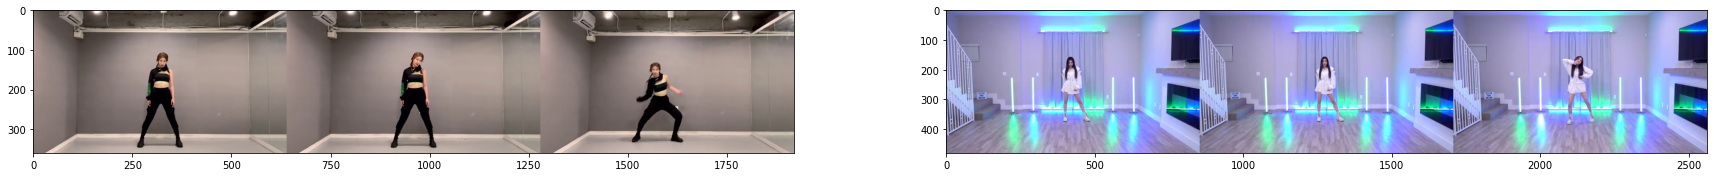

In [117]:
from PIL import Image
savage1_0 = np.array(Image.open('../kapao/data/datasets/kpop-cover-solo/intro-mp4/aespa-savage-intro1/frame0.jpg'))
savage2_0 = np.array(Image.open('../kapao/data/datasets/kpop-cover-solo/intro-mp4/aespa-savage-intro2/frame0.jpg'))
savage1_50 = np.array(Image.open('../kapao/data/datasets/kpop-cover-solo/intro-mp4/aespa-savage-intro1/frame49.jpg'))
savage2_50 = np.array(Image.open('../kapao/data/datasets/kpop-cover-solo/intro-mp4/aespa-savage-intro2/frame49.jpg'))
savage1_200 = np.array(Image.open('../kapao/data/datasets/kpop-cover-solo/intro-mp4/aespa-savage-intro1/frame199.jpg'))
savage2_200 = np.array(Image.open('../kapao/data/datasets/kpop-cover-solo/intro-mp4/aespa-savage-intro2/frame199.jpg'))

plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.imshow(np.concatenate([savage1_0, savage1_50, savage1_200], axis=1))
plt.subplot(1,2,2)
plt.imshow(np.concatenate([savage2_0, savage2_50, savage2_200], axis=1))


In [105]:
QUERY_CATEGORY = 'aespa-savage-intro1_pose'
print(pose_arrs[QUERY_CATEGORY]['pose'][0][0])
print(pose_arrs[QUERY_CATEGORY]['pose_hash'])

[[0.54673346 0.1143617 ]
 [0.5944006  0.09701004]
 [0.51039097 0.09120356]
 [0.62915355 0.10166537]
 [0.44358536 0.08802115]
 [0.70073726 0.20551294]
 [0.35236201 0.20405153]
 [0.74090313 0.35062205]
 [0.27290081 0.33592567]
 [0.77223969 0.47658304]
 [0.25169688 0.47819544]
 [0.63595029 0.45591087]
 [0.3832458  0.45572281]
 [0.73999681 0.68070857]
 [0.25266345 0.68872007]
 [0.8811756  0.9128081 ]
 [0.08740866 0.9157533 ]]
[array([0.91784148, 0.9186845 , 0.9153644 , 0.91806717, 0.95980733,
       0.97061777, 0.93475586, 0.83513611, 0.86536349, 0.89770405,
       0.8890842 , 0.87020697, 0.74429811, 0.79853047, 0.87634626,
       0.89768787, 0.        ])]


In [106]:
QUERY_CATEGORY = 'aespa-savage-intro2_pose'
print(pose_arrs[QUERY_CATEGORY]['pose'][0][0])
print(pose_arrs[QUERY_CATEGORY]['pose_hash'])

[[0.33041598 0.11124967]
 [0.37013353 0.09091632]
 [0.27788875 0.09084567]
 [0.42800503 0.08767519]
 [0.23285806 0.09283196]
 [0.56201912 0.19149404]
 [0.13979209 0.20696631]
 [0.62711958 0.32218327]
 [0.11578832 0.34404236]
 [0.56453512 0.45746741]
 [0.12234343 0.33549054]
 [0.48115308 0.46359225]
 [0.22081903 0.45637881]
 [0.65120443 0.6879919 ]
 [0.15728636 0.69299595]
 [0.8296179  0.90064285]
 [0.16044817 0.90406388]]
[array([0.76675634, 0.78165548, 0.78096784, 0.77739062, 0.77686435,
       0.77372413, 0.81776853, 0.84855258, 0.88661148, 0.82572792,
       0.83710426, 0.84077187, 0.77907892, 0.84689757, 0.86706412,
       0.85450125, 1.        ])]


## single linear interpolation for frames
### 입력 프레임 갯수가 타깃 프레임 갯수보다 작을 때: in 3, out 256
### (scalar, scalar, scalar)
#### 최대한 많은 in frame을 사용하면서, 반드시 구간별 interpolation count는 동일해야 함

1. 입력 프레임 갯수 / 타깃 프레임 갯수 확인, 비교
2. interframe_num = outframe_num - inframe_num = 253
3. fillin_num = interframe_num // (inframe_num - 1)
4.  fillin_num * inframe_num
5. 


## base scenario
- 인체 모션을 포함하는 데이터(영상 또는 pose sequence)는 하나의 짧은 동작을 포함한다고 가정한다.
- 짧은 동작의 시간 기준은 일반적으로 4초 이상, 10초 미만을 의미한다.
- 영상에서 일반적으로 적용되는 frame rate는 60 fps를 가정한다.
- 따라서, 대부분의 데이터는 통일시키고자 하는 256 frame보다 갯수가 크다.
    - ex. 1000개 프레임을 256개로 압축해야 한다.

### 문제: 갯수를 늘리는 것이 아니라 줄이는 linear interpolation?
- 1000개 프레임에서 약 4개 간격으로 인덱싱을 하면 끝나는 문제가 아닐까?

### in-depth 1: start frame과 target frame(256) 간의 차이가 거의 나지 않으면?
- ex. start = 290 / target = 256

### in-depth 2: 프레임 사이의 간격이 균일해야 한다 vs. 달라야 한다
- 균일성이 상관 없다면:
    - 인풋 데이터의 첫번째 데이터와 마지막 데이터를 **반드시** 포함
    - 나머지 n-2개의 사이 프레임은 우선적으로 1개 간격으로 채우고, 2개 간격으로 채우고, ... 하는 식으로 채운다.
- 균일성이 상관 있다면:
    - 가능한 인풋 데이터의 정보를 활용하되, 균일간격을 맞추기 위해 interpolation을 추가 수행
    - start frame을 우선 target frame의 2배수 ~ N배수로 expansion iterpolation한 뒤,
    - target frame 갯수만큼 indexing 한다.
    - **단, 이 경우 원본 정보를 일부 손실하게 되고, 부정확할 수 있는 interpolation 결과물을 쓰게 된다.** 

### decision
- 일단 균일성을 신경쓰지 않는 방향으로 구현하여 결과를 보고
- 균일성을 케어하는 대신 원본 데이터를 일부 손실하는 방식으로도 결과를 봐서
- 비교해 본다.

### If input frames > 256

In [2]:
def reduce_frame_to_target(input_data, target):
    start = input_data.shape[0]
    assert start >= target, "input frame number must be equal to or larger than target frame number"
    if start == 256:
        return input_data

    output_data = np.zeros((target, input_data.shape[1], input_data.shape[2]))

    # 첫번째 / 마지막 데이터 할당
    output_data[0,:,:] = input_data[0,:,:]
    output_data[-1,:,:] = input_data[-1,:,:]

    # 남아있는 갯수
    interval_cnt = target - 2    
    remains = start - target
    if remains == 0:
        remains_interval = 1
    else:
        remains_interval = max(target // remains, 1) # prevent zero division
    
    in_idx = 1 # input starting index
    out_idx = 1 # output starting index

    # 기본적으로 한개씩 집어넣기
    for j in range(1, interval_cnt + 1, max(target // interval_cnt, 1)): # 남아있는 갯수에 대해 for loop
        # 마지막을 제외한 모든 값이 채워지면 루프 종료
        if out_idx >= target - 1:
            break
        else:
            if j % remains_interval == 0: # remains를 추가로 더해줄 interval
                # print(in_idx)
                output_data[out_idx,:,:] = input_data[in_idx,:,:]
                in_idx += 2 # input 프레임 1개를 추가 스킵 (건너뛰기)
                out_idx += 1
                if out_idx >= target - 1:
                    break            
        output_data[out_idx,:,:] = input_data[in_idx,:,:]
        in_idx += 1
        out_idx += 1

    if output_data.shape[0] > target:
        return output_data[target, :, :]
    elif output_data.shape[0] < target:
        return None
    return output_data    

In [3]:
for f in [np.random.randint(256, 10000) for _ in range(10)]:
    sample_pose = np.random.random((f, 19, 2))
    sample_result = reduce_frame_to_target(sample_pose, 256)
    if type(sample_result) != np.ndarray:
        print(f)

In [4]:
sample_pose = np.random.random((259, 19, 2))
sample_result = reduce_frame_to_target(sample_pose, 256)

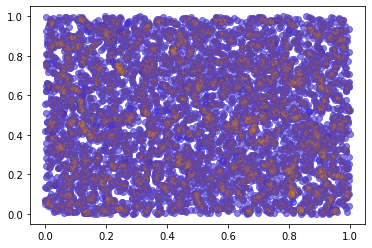

In [5]:
plt.scatter(sample_pose[:,:,0], sample_pose[:,:,1], alpha=.5, c='b')
plt.scatter(sample_result[:,:,0], sample_result[:,:,1], alpha=.1, c='orange')

### IF input frames < 256

Strategy
1. target 프레임 갯수보다 크게 만든다. (ex. in=25, target=256, in * 11 = 275)
  - 등간격으로, 빈 곳은 0으로 일단 채운다.
2. 크게 만든 input에 대해서 빈 칸을 linear interpolation 실시한다.
3. `reduce_frame_to_target` 함수를 이용하여 256개로 프레임 갯수를 조정한다.

(2, 1, 2)
(3, 1, 2)


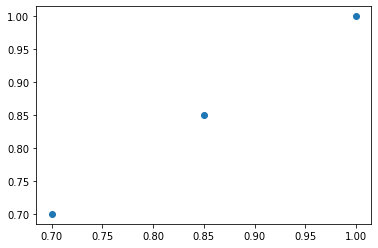

In [6]:
# linspace interpolation on 2d - test
test = np.array([[[1.0, 1.0]], [[0.7, 0.7]]])
print(test.shape)
test_lin = np.linspace(test[0,:,:], test[1,:,:], 3)
print(test_lin.shape)
# print(test_lin)

plt.scatter(test_lin[:,:,0], test_lin[:,:,1])

In [7]:
# 1. 256보다 크게, 등간격, 빈 곳은 우선 0 채우기

def expand_frame_to_target(input_data, target):

    if input_data.shape[0]==256:
        return input_data

    ### frame expansion
    start = input_data.shape[0]
    least_coef = target // start

    while (start - 1) * least_coef < target:
        least_coef += 1

    # debugging print    
    # print(f'start:{start}, least_coef:{least_coef}, mid_frame:{input_data.shape[0]*least_coef}, target:{target}')
    
    output_data = np.zeros((input_data.shape[0]*least_coef, input_data.shape[1], input_data.shape[2]))
    # print(output_data.shape)

    input_idx = 0
    for i in range(int(input_data.shape[0] * least_coef)):
        if i % least_coef==0:
            output_data[i] = input_data[input_idx]
            input_idx += 1

    # return output_data

    # delete last (least_coef - 1) frames
    output_data = output_data[:-1*(least_coef-1), :, :]
    # print('mid-cut shape', output_data.shape)
    # print('mid-cut last element', output_data[-1,:,:])

    ### interpolate in-between frames
    for i in range(output_data.shape[0]):
        # if i % least_coef == 0:
        try:
            # print(i, least_coef*i, least_coef*(i+1))
            output_data[least_coef*i:least_coef*(i+1), :, :] = np.linspace(output_data[least_coef*i,:,:],
                                                                            output_data[least_coef*(i+1),:,:],
                                                                            least_coef)
        except:
            # print('break')
            break
    
    ## reduce frames to target number
    output_data = reduce_frame_to_target(output_data, target)

    # print(output_data.shape)
    return output_data

In [8]:
for f in [np.random.randint(10, 99) for _ in range(1000)]:
    sample_pose = np.random.random((f, 19, 2))
    # print(sample_pose.shape)
    sample_result = expand_frame_to_target(sample_pose, 256)
    if sample_result.shape[0] != 256:
        print('error')

    for i in range(sample_result.shape[0]):
        frame_sum = sample_result[i, :, :].sum()
        if frame_sum == 0:
            print('error')

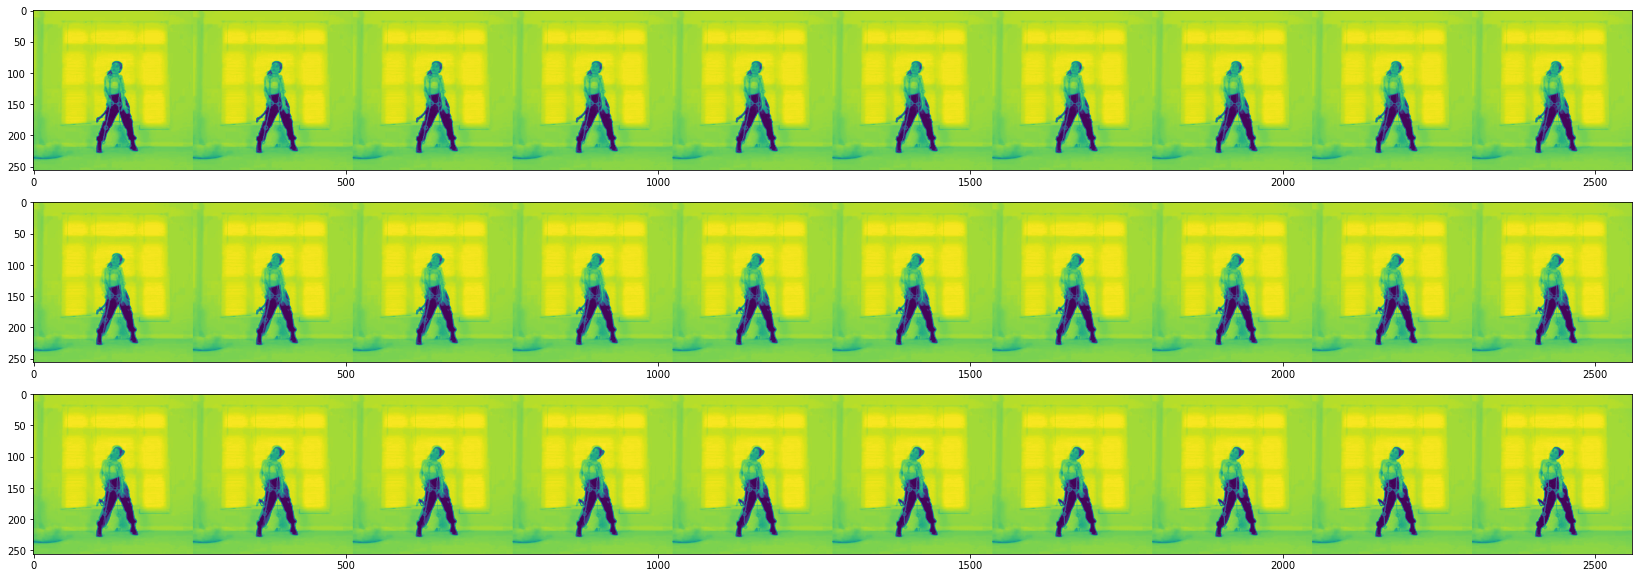

In [105]:
# fig = plt.figure(figsize=(30,10))
# for k in range(1, 4):
#     # plt.figure(figsize=(30, 10))
#     fig.add_subplot(3, 1, k)
#     plt.imshow(np.concatenate([linspace[i] for i in range(10*(k-1), 10*k)], axis=1))

## Frame grouping

In [9]:
cluster1 = [expand_frame_to_target(np.random.random((np.random.randint(10, 100), 19, 2)), 256) for _ in range(100)]
cluster2 = [expand_frame_to_target(np.random.random((np.random.randint(10, 100), 19, 2)) * 3, 256) for _ in range(100)] 
cluster3 = [reduce_frame_to_target(np.random.random((np.random.randint(300, 1000), 19, 2)) * 3, 256) for _ in range(100)] 

In [10]:
len(cluster1), cluster1[0].shape, len(cluster2), cluster2[0].shape, cluster3[0].shape, len(cluster3), 

(100, (256, 19, 2), 100, (256, 19, 2), (256, 19, 2), 100)

In [11]:
def group_frame_to_target(input_data, target=16):
    num_group = int(input_data.shape[0] / target)
    return [input_data[num_group*i : num_group*(i+1), :, :] for i in range(num_group)]

In [12]:
cluster1 = [group_frame_to_target(item) for item in cluster1]
cluster2 = [group_frame_to_target(item) for item in cluster2]
cluster3 = [group_frame_to_target(item) for item in cluster3]

# cluster
## video - 100
### video group - 16
#### frame - 19,2

In [13]:
cluster1[0][0][0].shape

(19, 2)

In [14]:
len(cluster1[0]), cluster1[0][0].shape

(16, (16, 19, 2))

## 1. Singular Value Decomposition (SVD)
SVD는 매우 많은 피처를 가진 고차원 행렬을 저차원 행렬로 분리하는 행렬 분해 기법입니다. 특히 이런 행렬 분해를 수행하면서 원본 행렬에서 잠재된 요소를 추출하기 때문에 토픽 모델링이나 추천 시스템에 활발하게 사용됩니다.

### parameter settings
- N = 16
- r = 2

### source
- https://darkpgmr.tistory.com/106
- https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-20-%ED%8A%B9%EC%9D%B4%EA%B0%92-%EB%B6%84%ED%95%B4Singular-Value-Decomposition

## Practice: Image Compression using SVD

https://www.kaggle.com/code/function9/singular-value-decomposition-image-compression

In [61]:
filenames = os.listdir('./test_img/')
filenames

['gosegu1.jpg', 'gosegu2.jpg', 'gosegu3.jpg', 'gosegu4.jpg']

In [62]:
img = Image.open('./test_img/' + filenames[randrange(len(filenames))]).convert('L').resize((256,256))

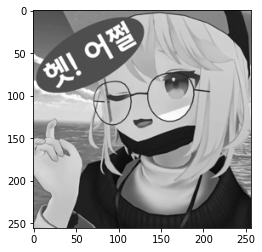

In [63]:
plt.imshow(img, cmap='gray')

Text(0.5, 1.0, 'Cumulative Sum of Sigma Matrix')

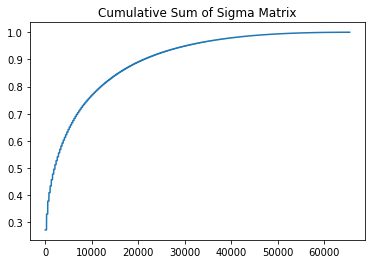

In [64]:
# Compute Singular Value Decomposition
U,S,V = np.linalg.svd(np.array(img), full_matrices=False)
S = np.diag(S)

plt.plot(np.cumsum(S)/np.sum(S))
plt.title('Cumulative Sum of Sigma Matrix')

### image reconstruction
The energy in the first I columns can be caluculated using the following formula

![](https://i.imgur.com/VyUtygs.png)

The first 2 columns contained 90.27316799082895% of the original energy of the image


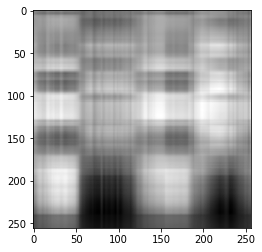

In [69]:
# Only keeping the first 2 columns of the SVD matrices, truncating the rest and reconstructing the original image
r = 2
reconstruction = U[:,:r] @ S[0:r,:r] @ V[:r,:]
energy = 0
for i in range(r):
    energy = energy + S[i][i]*S[i][i]
energy = energy / np.sum(np.square(S))
print('The first ' + str(r) + ' columns contained ' + str(energy * 100) + '% of the original energy of the image')

plt.imshow(reconstruction, cmap='gray')

In [101]:
reconstruction.shape

(256, 256)

## 2D Pose Sequence Compression using SVD

In [16]:
# numpy의 svd 모듈 import
import numpy as np
from numpy.linalg import svd

In [17]:
def SVD_reconstruct(frame, r = 2):
    # for each frame
    U, Sigma, Vt = svd(frame)
    # print(Sigma)
    Sigma = np.diag(Sigma)
    # print(Sigma)
    return U[:,:r] @ Sigma[:r,:r] @ Vt[:r,:]

In [18]:
cluster1_low = np.array([[[SVD_reconstruct(f) for f in vid] for vid in vidgroup] for vidgroup in cluster1])
cluster2_low = np.array([[[SVD_reconstruct(f) for f in vid] for vid in vidgroup] for vidgroup in cluster2])
cluster3_low = np.array([[[SVD_reconstruct(f) for f in vid] for vid in vidgroup] for vidgroup in cluster3])

In [19]:
cluster1_low.shape

(100, 16, 16, 19, 2)

In [20]:
def calculate_low_rank(video_groups):
    # expected input dimension : (video_group_num, 256 / video_group_num, keypoint_num, 2)
    # example: (16, 16, 19, 2)
    
    video_group_cnt = video_groups.shape[0] # 16
    keypoint_cnt = video_groups.shape[2] # 19

    out = np.zeros(video_groups.shape[1:]) # (16,19,2)
    
    for i in range(video_group_cnt):
        for j in range(keypoint_cnt):
            out[i,j,0] = video_groups[i, :, j, 0].mean()
            out[i,j,1] = video_groups[i, :, j, 1].mean()

    return out

In [21]:
cluster1_low_rank = np.array([calculate_low_rank(group) for group in cluster1_low])
cluster2_low_rank = np.array([calculate_low_rank(group) for group in cluster2_low])
cluster3_low_rank = np.array([calculate_low_rank(group) for group in cluster3_low])

In [22]:
# (처리 전) 각 비디오는 16개 비디오 그룹으로 구성되며, 각 비디오 그룹은 16개의 프레임으로 구성되며, 각 프레임은 19개의 2차원 키포인트 좌표로 표현되었다.
# (처리 후) 각 비디오는 16개 비디오 그룹으로 구성되며, 각 비디오는 16개 프레임을 평균 낸 19개의 2차원 키포인트 좌표로 표현되었다.

cluster1_low_rank.shape 

(100, 16, 19, 2)

In [17]:
# video_groups_low_rank = np.array([[SVD_reconstruct(frame) for frame in video_group] for video_group in video_groups])

In [18]:
# video_groups_low_rank_calc = np.zeros(video_groups_low_rank.shape[1:])

# for i in range(len(video_groups_low_rank)):
#     for j in range(video_groups_low_rank.shape[2]):
#     # print(i)
#         video_groups_low_rank_calc[i, j, 0] = video_groups_low_rank[i, :, j, 0].mean()
#         video_groups_low_rank_calc[i, j, 1] = video_groups_low_rank[i, :, j, 1].mean()


In [ ]:
# # low rank calculation finished.
# print(video_groups_low_rank_calc.shape)
# video_groups_low_rank_calc

### sample visualization

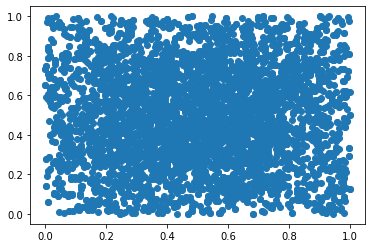

In [20]:
plt.scatter(sample_result[:,:,0], sample_result[:,:,1])

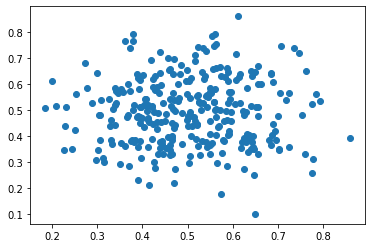

In [21]:
plt.scatter(video_groups_low_rank_calc[:, :, 0], video_groups_low_rank_calc[:,:,1])

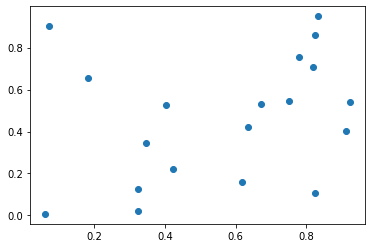

In [22]:
plt.scatter(video_groups[0][0,:,0], video_groups[0][0,:,1])

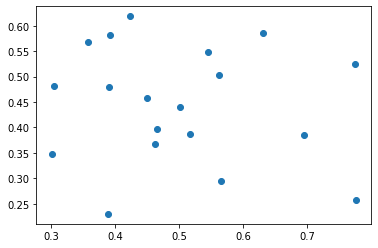

In [23]:
plt.scatter(video_groups_low_rank_calc[0, :, 0], 
            video_groups_low_rank_calc[0,:,1])

## Low-rank frame compression: 2D DWT

https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html

### pywt.dwt2(data, wavelet, mode='symmetric', axes=(-2, -1))
2D Discrete Wavelet Transform.

Parameters:	
- data : array_like
  - 2D array with input data
- wavelet : Wavelet object or name string, or 2-tuple of wavelets
    - Wavelet to use. This can also be a tuple containing a wavelet to apply along each axis in axes.
- mode : str or 2-tuple of strings, optional
  - Signal extension mode, see Modes. This can also be a tuple of modes specifying the mode to use on each axis in axes.
- axes : 2-tuple of ints, optional
  - Axes over which to compute the DWT. Repeated elements mean the DWT will be performed multiple times along these axes.

Returns:	
- (cA, (cH, cV, cD)) : tuple
  - Approximation, horizontal detail, vertical detail and diagonal detail coefficients respectively. Horizontal refers to array axis 0 (or axes[0] for user-specified axes).

In [24]:
import pywt

In [25]:
def approximate_low_rank(cluster):
    LL, (LH, HL, HH) = pywt.dwt2(cluster, "haar")
    # print(LL.shape)

    d_a = LL.shape[-2]
    d_b = LL.shape[-1]

    result = (LL.sum(axis=-2) / (d_a * d_b)).ravel()
    # print(result.shape)
    return result

In [26]:
approximate_low_rank(cluster1_low_rank)

array([1.01113732, 1.03208907, 1.03943972, ..., 0.95616965, 0.92272118,
       1.03257192])

In [27]:
print(cluster1_low_rank[0].shape)
approximate_low_rank(cluster1_low_rank[0])

(16, 19, 2)


array([1.01113732, 1.03208907, 1.03943972, 1.03922358, 0.94858845,
       1.03172583, 0.96126962, 1.02747092, 0.9615008 , 1.07719758,
       1.01813487, 0.98668182, 0.97201482, 0.98138398, 0.97265264,
       0.88433256])

# Summing up

In [79]:
# create sample clusters
cluster1 = [expand_frame_to_target(np.random.random((np.random.randint(10, 100), 19, 2)), 256) for _ in range(100)]
cluster2 = [expand_frame_to_target(np.random.random((np.random.randint(10, 100), 19, 2)) * 3, 256) for _ in range(100)] 
cluster3 = [reduce_frame_to_target(np.random.random((np.random.randint(300, 1000), 19, 2)) * 3, 256) for _ in range(100)]

In [111]:
# video grouping into 16
cluster1_group = [group_frame_to_target(item) for item in cluster1]
cluster2_group = [group_frame_to_target(item) for item in cluster2]
cluster3_group = [group_frame_to_target(item) for item in cluster3]

# SVD recon for each frame
cluster1_low = np.array([[[SVD_reconstruct(f) for f in vid] for vid in vidgroup] for vidgroup in cluster1_group])
cluster2_low = np.array([[[SVD_reconstruct(f) for f in vid] for vid in vidgroup] for vidgroup in cluster2_group])
cluster3_low = np.array([[[SVD_reconstruct(f) for f in vid] for vid in vidgroup] for vidgroup in cluster3_group])

# calculate low-rank for each video group
cluster1_low_rank = np.array([calculate_low_rank(vidgroup) for vidgroup in cluster1_low])
cluster2_low_rank = np.array([calculate_low_rank(vidgroup) for vidgroup in cluster2_low])
cluster3_low_rank = np.array([calculate_low_rank(vidgroup) for vidgroup in cluster3_low])

# approximate low-rank for each video -> finalize video hashing
cluster1_hash = np.array([approximate_low_rank(vidgroup) for vidgroup in cluster1_low_rank])
cluster2_hash = np.array([approximate_low_rank(vidgroup) for vidgroup in cluster2_low_rank])
cluster3_hash = np.array([approximate_low_rank(vidgroup) for vidgroup in cluster3_low_rank])

In [117]:
def hash_video_svd_wavelet(video, group_num=16, target_frame=256):
    if len(video) > target_frame:
        video = reduce_frame_to_target(video, target_frame)
    else:
        video = expand_frame_to_target(video, target_frame)

    groups = group_frame_to_target(video, group_num)
    low = np.array([[SVD_reconstruct(f) for f in group] for group in groups])
    lowrank = np.array(calculate_low_rank(low))

    return np.array(approximate_low_rank(lowrank))

In [119]:
test_sample = np.random.random((np.random.randint(10, 100), 19, 2))
print(test_sample.shape)
hash_video_svd_wavelet(test_sample)
# test_sample.shape

(53, 19, 2)


array([0.99718942, 1.04315679, 1.06053757, 1.0645782 , 0.99790701,
       0.9817221 , 1.01339702, 0.95467556, 0.98073781, 1.00598463,
       0.92878515, 0.93467128, 0.92106969, 0.9089955 , 1.0287659 ,
       0.99343228])

### Quantize (optional)

In [56]:
from decimal import *
getcontext()

Context(prec=28, rounding=ROUND_HALF_EVEN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[FloatOperation], traps=[InvalidOperation, DivisionByZero, Overflow])

In [51]:
video_groups_low_rank_approx[0] , Decimal(video_groups_low_rank_approx[0])

(0.9527924663161251,
 Decimal('0.9527924663161251306320309595321305096149444580078125'))

In [77]:
video_groups_low_rank_approx # final video hash

array([0.95279247, 1.00451099, 0.95741002, 1.04788102, 1.01609973,
       1.01777303, 1.00653662, 0.95813586, 1.00549419, 1.02069794,
       0.94199915, 1.0500335 , 0.99918222, 1.05883532, 0.9681839 ,
       0.98085232])

### similarity -> Pearson coef

In [87]:
from scipy.stats import pearsonr

In [88]:
# cluster 2, 3 should be similar to each other! (different frame size but similar coordinate scale)
# cluster1 = [expand_frame_to_target(np.random.random((np.random.randint(10, 100), 19, 2)), 256) for _ in range(100)]
# cluster2 = [expand_frame_to_target(np.random.random((np.random.randint(10, 100), 19, 2)) * 3, 256) for _ in range(100)] 
# cluster3 = [reduce_frame_to_target(np.random.random((np.random.randint(300, 1000), 19, 2)) * 3, 256) for _ in range(100)]

cluster1_sample = cluster1_hash[np.random.randint(0, 100)]
cluster2_sample = cluster2_hash[np.random.randint(0, 100)]
cluster3_sample = cluster3_hash[np.random.randint(0, 100)]

In [92]:
def pearsonr_test(sample, cluster):
    p = 0
    for cluster_item in cluster:
        p += pearsonr(cluster_item, sample)[0]
    return p


In [98]:
c2_c1_pearson = pearsonr_test(cluster2_sample, cluster1_hash)
c2_c2_pearson = pearsonr_test(cluster2_sample, cluster2_hash)
c2_c3_pearson = pearsonr_test(cluster2_sample, cluster3_hash)

In [99]:
c2_c1_pearson, c2_c2_pearson, c2_c3_pearson

(-4.541510228396212, -0.7466723198142535, -1.3663878614312126)

# 테스트

## Python 연산 최적화
- https://koreapy.tistory.com/1483
- https://camel-it.tistory.com/140

In [ ]:


sample_float32_hash1 = np.array([np.random.random() for _ in range(16)], dtype=np.float32)
sample_float32_hash2 = np.array([np.random.random() for _ in range(16)], dtype=np.float32)

sample_int8_hash1 = np.random.randint(0, 256, 16, dtype=np.uint8)
sample_int8_hash2 = np.random.randint(0, 256, 16, dtype=np.uint8)

import time

def pearson_float32(a, b):
    for i in range(10000):
        pearsonr(a,b)

def pearson_int8(a, b):
    for i in range(10000):
        pearsonr(a,b)

In [ ]:
s = time.time()
pearson_float32(sample_float32_hash1, sample_float32_hash2)
e = time.time()

In [ ]:
s = time.time()
pearson_float32(sample_int8_hash1, sample_int8_hash2)
e = time.time()